##### Tous les imports nécessaires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, iirnotch
from io import StringIO

##### On charge les données et on les nettoie

In [2]:
file_path1 = 'emg+dataset+in+lower+limb/SEMG_DB1/N_TXT/1Nmar.txt'

def load_and_process_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        content = '\n'.join(content.split('\n')[6:])
    
    data = pd.read_csv(StringIO(content), sep='\t', header=None, names=['RF', 'BF', 'VM', 'ST', 'FX'])
    data.dropna(inplace=True)
    data['Time'] = data.index
    return data

#Filtre passe-bande
def bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

#Filtre notch
def notch_filter(data, notch_freq=50, fs=1000, quality_factor=30):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data)

#Normalisation des données
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

data = load_and_process_data(file_path1)

# Application des filtres et de la normalisation sur chaque signal
for col in ['RF', 'BF', 'VM', 'ST']:
    data[col] = bandpass_filter(data[col])
    data[col] = notch_filter(data[col])
    data[col] = normalize_data(data[col])

print(data.head())

         RF        BF        VM        ST    FX  Time
0  0.522072  0.377270  0.478975  0.442357  57.6     0
1  0.517630  0.399627  0.458251  0.462805  57.5     1
2  0.520627  0.376228  0.466271  0.471472  57.3     2
3  0.521994  0.378373  0.487813  0.461059  57.1     3
4  0.531031  0.413314  0.515392  0.437844  56.9     4


##### Obtention des maximums locaux pour déterminer les cycles

In [3]:
# Détection des pics pour identifier les cycles de marche
peaks, _ = find_peaks(data['FX'], height=np.mean(data['FX']))
print(f'Nombre de pics détectés : {len(peaks)}')
print(peaks)

#On determine la durée d'un cycle moyen
cycle_lengths = np.diff(peaks)
mean_cycle_length = np.mean(cycle_lengths)
print(f'Longueur moyenne des cycles : {mean_cycle_length}')

# Décalage des cycles pour que le pic soit à 70%
shift_ratio = 0.7
adjusted_peaks = []

for i in range(len(peaks)):
    shift_amount = int(mean_cycle_length * shift_ratio)
    adjusted_start = max(0, peaks[i] - shift_amount)  # Éviter les index négatifs
    adjusted_peaks.append(adjusted_start)

# Vérification des cycles estimés en l'absence d'un pic
while adjusted_peaks[-1] + mean_cycle_length < len(data):
    new_cycle_start = adjusted_peaks[-1] + mean_cycle_length
    adjusted_peaks.append(new_cycle_start)
    
print(f'Nombre de débuts de cycles ajustés : {len(adjusted_peaks)}')
print(adjusted_peaks)

Nombre de pics détectés : 4
[1144 2380 3649 4930]
Longueur moyenne des cycles : 1262.0
Nombre de débuts de cycles ajustés : 5
[261, 1497, 2766, 4047, 5309.0]


##### Affichage du du graphique de flexion du genoux avec les differents cycles

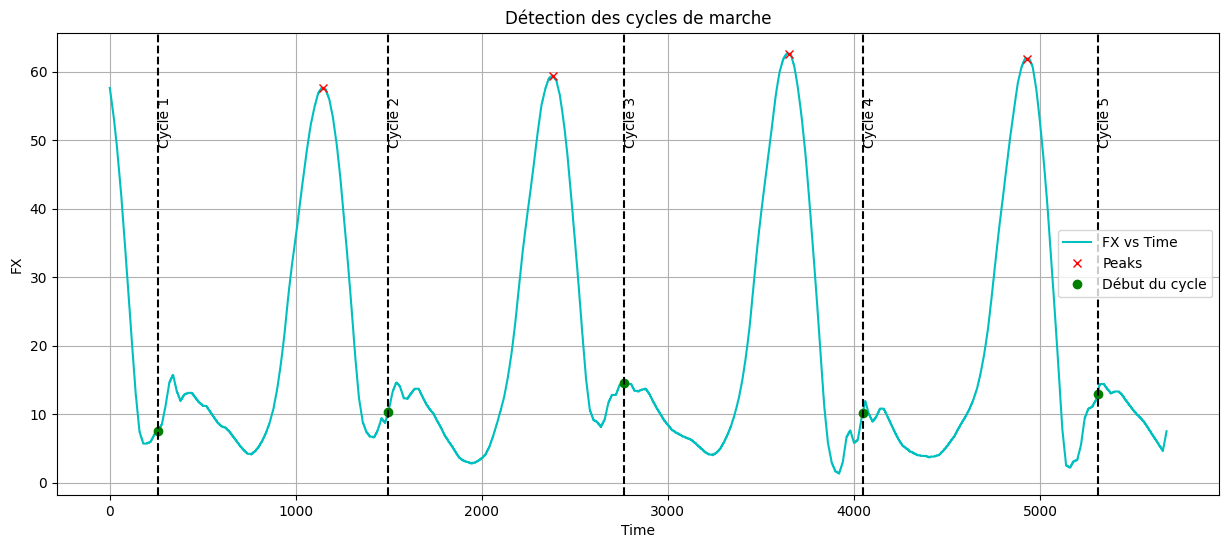

In [4]:
# Affichage du signal FX avec les cycles marqués
plt.figure(figsize=(15, 6))
plt.plot(data['Time'], data['FX'], label='FX vs Time', color='c')
plt.plot(data['Time'][peaks], data['FX'][peaks], 'rx', label='Peaks')
plt.plot(data['Time'][adjusted_peaks], data['FX'][adjusted_peaks], 'go', label='Début du cycle')

for i, start in enumerate(adjusted_peaks):
    plt.axvline(x=data['Time'][start], color='k', linestyle='--')
    plt.text(data['Time'][start], max(data['FX']) * 0.9, f'Cycle {i+1}', rotation=90, verticalalignment='top')

plt.xlabel('Time')
plt.ylabel('FX')
plt.title('Détection des cycles de marche')
plt.legend()
plt.grid(True)
plt.show()


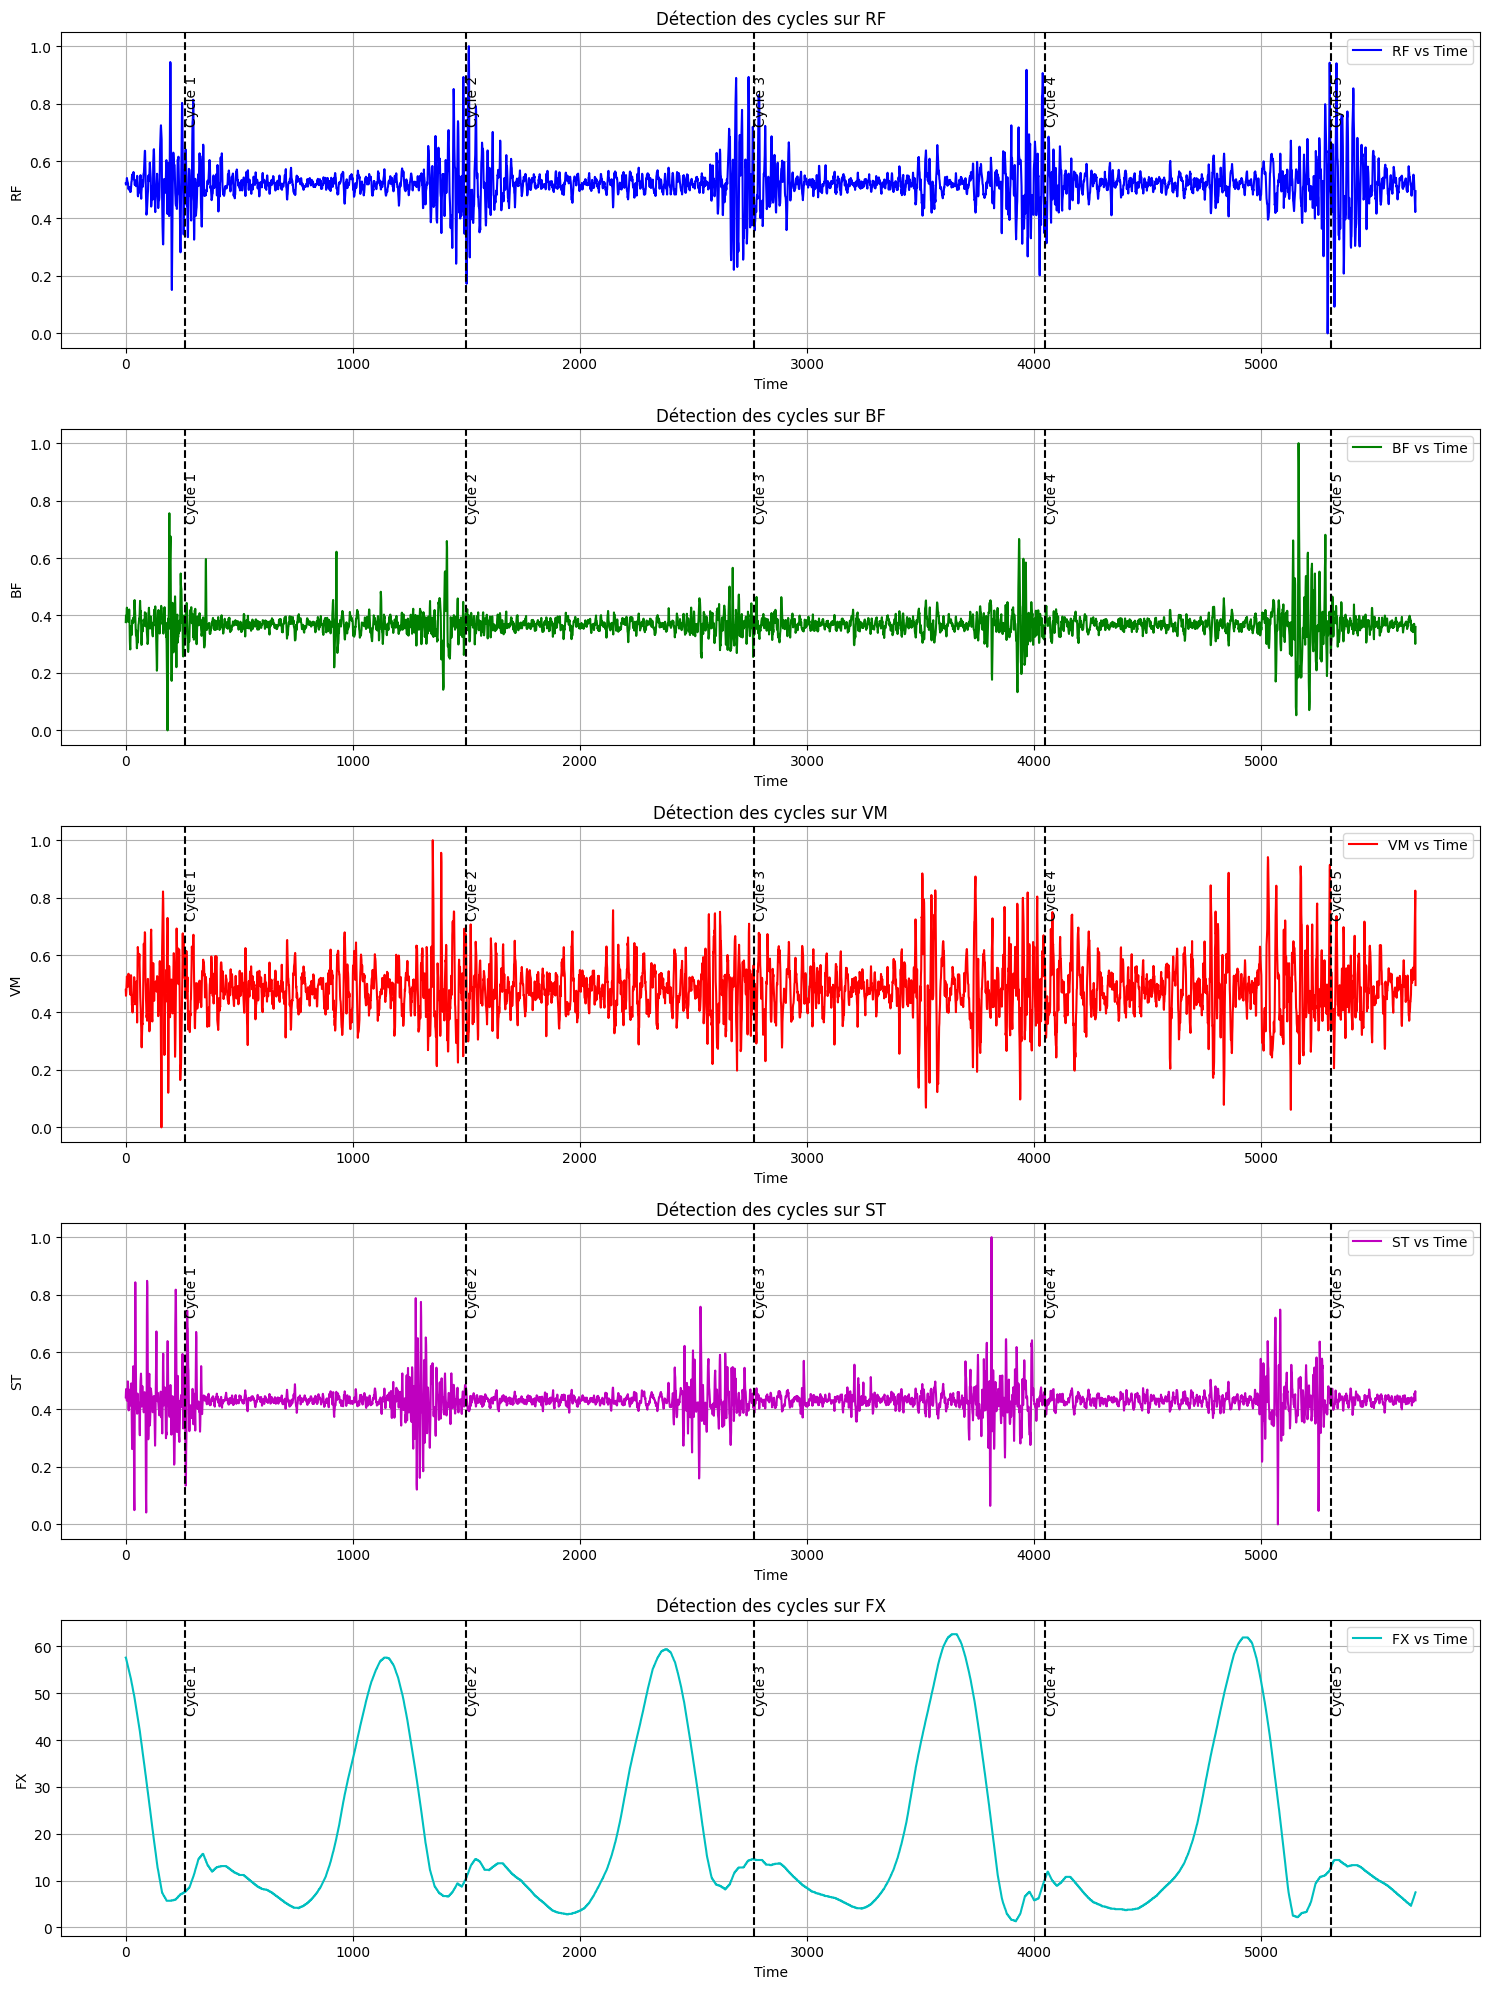

In [5]:
# Liste des colonnes à afficher
columns = ['RF', 'BF', 'VM', 'ST', 'FX']
colors = ['b', 'g', 'r', 'm', 'c']

# Création des graphiques pour chaque signal avec les cycles marqués
fig, axs = plt.subplots(len(columns), figsize=(15, 20))
for i, col in enumerate(columns):
    axs[i].plot(data['Time'], data[col], label=f'{col} vs Time', color=colors[i])
    for j, start in enumerate(adjusted_peaks):
        axs[i].axvline(x=data['Time'][start], color='k', linestyle='--')
        axs[i].text(data['Time'][start], max(data[col]) * 0.9, f'Cycle {j+1}', rotation=90, verticalalignment='top')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(col)
    axs[i].set_title(f'Détection des cycles sur {col}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

##### Filtrage

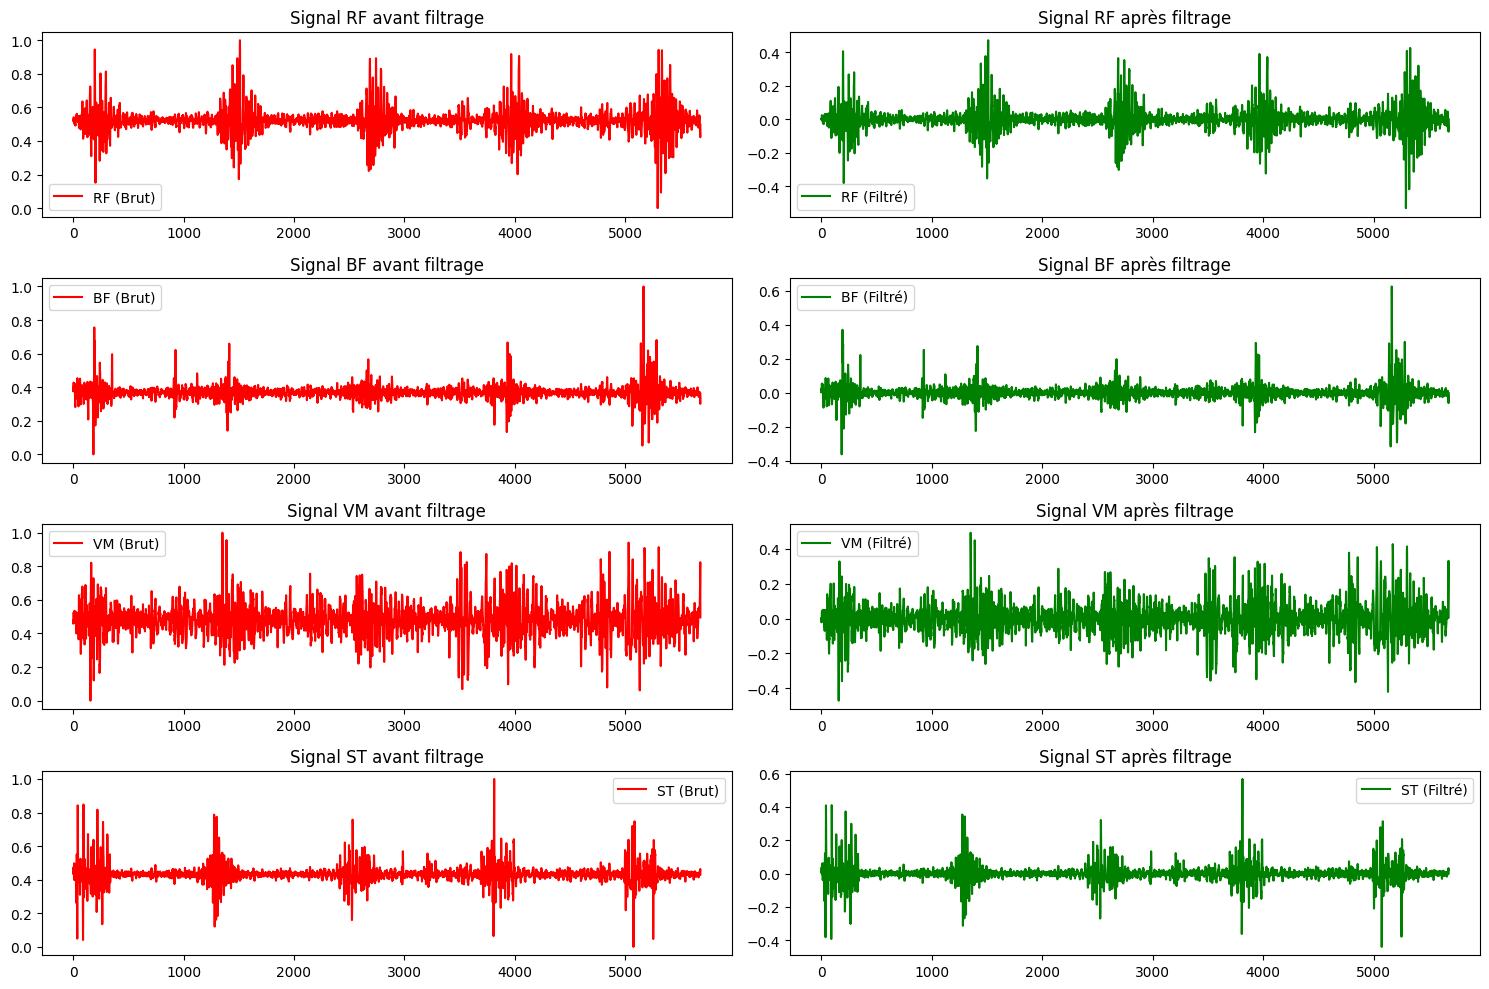

In [6]:
# Fonction de création d'un filtre passe-bande
def bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Fonction de création d'un filtre Notch (suppression 50 Hz)
def notch_filter(data, notch_freq=50, fs=1000, quality_factor=100):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data)

# Appliquer les filtres sur chaque signal EMG
filtered_data = data.copy()
sampling_rate = 1000  # Taux d'échantillonnage en Hz (à ajuster selon ton dataset)

for col in ['RF', 'BF', 'VM', 'ST']:
    filtered_data[col] = bandpass_filter(data[col], fs=sampling_rate)
    filtered_data[col] = notch_filter(filtered_data[col], fs=sampling_rate)

# Vérification du filtrage en affichant les signaux avant et après
fig, axs = plt.subplots(4, 2, figsize=(15, 10))

for i, col in enumerate(['RF', 'BF', 'VM', 'ST']):
    axs[i, 0].plot(data['Time'], data[col], color='r', label=f'{col} (Brut)')
    axs[i, 0].set_title(f'Signal {col} avant filtrage')
    axs[i, 0].legend()
    
    axs[i, 1].plot(data['Time'], filtered_data[col], color='g', label=f'{col} (Filtré)')
    axs[i, 1].set_title(f'Signal {col} après filtrage')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()